# Performance as well as Validation benchmarks for activation function implementations in the different frameworks

# GPU versions only

Windows 11
i7 11800H
Nvidia 3050 Ti


In [ ]:
! pip install crysx_nn

     |████████████████████████████████| 40.1 MB 13.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.0 MB/s 
     |████████████████████████████████| 14.5 MB 23.3 MB/s 
     |████████████████████████████████| 26.3 MB 7.6 MB/s 
  Created wheel for crysx-nn: filename=crysx_nn-0.1.3-py3-none-any.whl size=15700 sha256=393c308e7bc534333817fad0ed12b3b09526791be00074e0400ae6b932b6e98f
  Stored in directory: /root/.cache/pip/wheels/ca/3c/7a/2a82cf0413e646c0b0e78e1c74154fdca97026c57d23cc7b9f
Successfully built crysx-nn
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
ERROR: pip's

In [ ]:
! pip install IPython==7.7.0


     |████████████████████████████████| 774 kB 5.1 MB/s 
     |████████████████████████████████| 340 kB 46.2 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: IPython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 2.0.10 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.7.0 which is incompatible.


In [ ]:


import numpy as np
np.show_config()
print('numpy',np.__version__)
import matplotlib.pyplot as plt

# Import activation functions from crysx_nn
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import ReLU, ReLU_grad

# PyTorch
import torch
print('torch',torch.__version__)

# Tensorflow
import tensorflow as tf
print('tensorflow',tf.__version__)

import cupy as cp
print('cupy',cp.__version__)

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
numpy 1.19.2
torch 1.10.0+cu111
tensorflow 2.7.0
cupy 9.4.0


## Ensure that evertyhing is only using GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

0
1
Tesla K80


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print(tf.test.is_built_with_cuda())

True


In [ ]:
# tf.debugging.set_log_device_placement(True)

In [ ]:
def Softmax(x):
    '''
    Performs the softmax activation on a given set of inputs
    Input: x (N,k) ndarray (N: no. of samples, k: no. of nodes)
    Returns: 
    Note: Works for 2D arrays only(rows for samples, columns for nodes/outputs)
    '''
    e_x = cp.exp(x - cp.max(x)) # For stability
#     return e_x / e_x.sum(axis=1, keepdims=True) # only difference
    return e_x / e_x.sum(axis=1).reshape((-1, 1)) # Alternative of keepdims=True for Numba compatibility

def Softmax_grad(x): # Best implementation (VERY FAST)
    '''Returns the jacobian of the Softmax function for the given set of inputs.
    Inputs:
    x: should be a 2d array where the rows correspond to the samples
        and the columns correspond to the nodes.
    Returns: jacobian
    '''
    s = Softmax(x)
    a = cp.eye(s.shape[-1])
    temp1 = cp.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=cp.float32)
    temp2 = cp.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=cp.float32)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            for k in range(s.shape[1]):
                temp1[i,j,k] = s[i,j]*a[j,k]
                temp2[i,j,k] = s[i,j]*s[i,k]
    return temp1-temp2

def Sigmoid(x):
    return 1/(1+cp.exp(-x))

def Sigmoid_grad(x):
    return cp.exp(-x)/(cp.exp(-x)+1)**2


def ReLU(x):
    # Broadcasting seems expensive compared to TF and PyTorch
    # return np.maximum(0.,x)
    a = cp.zeros(x.shape,dtype=cp.float32)
    return cp.maximum(a,x)

def ReLU_grad(x):
    return cp.greater(x, 0.).astype(cp.float32)

## Generate an input `2d array` of type `float32` for benchmark (let's say using `torch`)

In [ ]:
X_torch = torch.randn((300,100),requires_grad=True)
X_torch = X_torch.cuda()
print(X_torch.cpu())

tensor([[-1.0295,  2.0987,  0.8457,  ..., -0.3645, -0.6727, -0.9104],
        [-0.7141, -0.1804, -0.4025,  ...,  0.0691, -0.7614,  0.6997],
        [-0.3864, -1.0156,  1.7384,  ..., -0.3077, -1.0511,  0.4586],
        ...,
        [ 0.1953,  0.9764, -1.0313,  ..., -1.0434, -1.1354, -0.4758],
        [ 0.1263, -0.8687,  0.9475,  ..., -0.2371,  0.3656,  0.7102],
        [ 0.7393, -0.3089, -0.0970,  ..., -0.4207, -0.7622,  1.3727]],
       grad_fn=<ToCopyBackward0>)


## Convert it to numpy for `crysx_nn`

In [ ]:
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
print(X_crysx_nn.dtype)

float32


## Now finally convert it to a tensorflow tensor

In [ ]:
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

## Benchmark ReLU

### Confirm that all frameworks give the same results

In [ ]:
# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)

# CrysX
relu_crysx_nn_value = ReLU(X_cupy)

# Tensorflow
relu_tf_value = tf.nn.relu(X_tf)#tf.keras.activations.relu(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(relu_torch_value.cpu().detach().numpy() - relu_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(relu_torch_value.cpu().detach().numpy() - cp.asnumpy(relu_crysx_nn_value)).max())

Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

In [ ]:
# Torch
print('PyTorch')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
%timeit -n 1000 relu_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 1000 ReLU(X_cupy)

# Tensorflow
print('Tensorflow')
%timeit -n 1000 tf.keras.activations.relu(X_tf)


PyTorch
43.8 µs ± 5.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CrysX-NN (crysx_nn)
61.6 µs ± 5.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensorflow
105 µs ± 7.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Compare performance with arrays of different sizes

In [ ]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.randn((n_size,n_size),requires_grad=True)
    X_torch = X_torch.cuda()
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    X_cupy = cp.asarray(X_crysx_nn)
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
    time = %timeit -n 500 -o relu_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 500 -o ReLU(X_cupy)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 500 -o tf.nn.relu(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))

40.5 µs ± 2.96 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
50.8 µs ± 3.18 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
65.4 µs ± 5.97 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
62.5 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
64.2 µs ± 7.08 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
67.1 µs ± 7.73 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
45.3 µs ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
133 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
109 µs ± 38 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
98.7 µs ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
284 µs ± 9.76 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
The slowest run took 15.35 times longer than the fastest. This could mean that an intermediate result is being cached.
154 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
The slowest run took 13.

### Plot the results

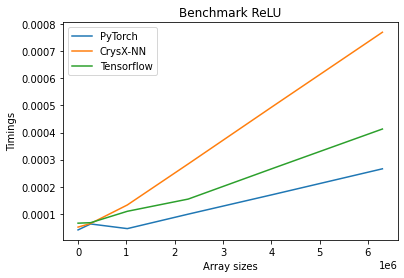

In [ ]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark ReLU')
plt.show()

## Benchmark ReLU derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [ ]:
def tf_relu_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        relu_values = tf.nn.relu(x)
    grad = g.gradient(relu_values, x)
    return grad#.numpy()

In [ ]:
def torch_relu_grad(relu_values, x):
    device='cuda'
    gradient = torch.autograd.grad(outputs=relu_values, inputs=x,
                          grad_outputs=torch.ones(relu_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [ ]:
# Torch input
X_torch = torch.randn((1000,1000),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
gradientsTorch = torch_relu_grad(relu_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = ReLU_grad(X_cupy)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_relu_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
gradientsTF = g.gradient(relu_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - cp.asnumpy(gradientsCrysx)).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [ ]:
# Torch
print('PyTorch gradient only')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
%timeit -n 100 torch_relu_grad(relu_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 ReLU_grad(X_cupy)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
# %timeit -n 100 g.gradient(relu_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_relu_grad(X_tf)

print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.relu(X_tf)


PyTorch gradient only
1.61 ms ± 74.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
110 µs ± 3.81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
687 µs ± 64.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
102 µs ± 8.31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Sigmoid

### Confirm that all frameworks give the same results

In [ ]:
# Torch input
X_torch = torch.randn((1000,1000),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)

# CrysX
sigmoid_crysx_nn_value = Sigmoid(X_cupy)

# Tensorflow
sigmoid_tf_value = tf.keras.activations.sigmoid(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(sigmoid_torch_value.cpu().detach().numpy() - sigmoid_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(sigmoid_torch_value.cpu().detach().numpy() - cp.asnumpy(sigmoid_crysx_nn_value)).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

In [ ]:
# Torch
print('PyTorch')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
%timeit -n 100 sigmoid_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Sigmoid(X_cupy)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)


PyTorch
33.9 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)
227 µs ± 51.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
113 µs ± 31.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [ ]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.randn((n_size,n_size),requires_grad=True)
    X_torch = X_torch.cuda()
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    X_cupy = cp.asarray(X_crysx_nn)
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o sigmoid_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Sigmoid(X_cupy)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.sigmoid(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

15 µs ± 1.43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
84.7 µs ± 8.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
57.2 µs ± 8.62 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.2 µs ± 490 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
83.6 µs ± 8.67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
61.2 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.6 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
255 µs ± 88.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
55.5 µs ± 3.45 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20 µs ± 5.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 6.88 times longer than the fastest. This could mean that an intermediate result is being cached.
546 µs ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52.4 µs ± 4.29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15 µs ± 1.61 µs per loop (m

### Plot the results

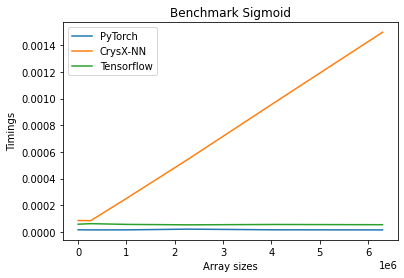

In [ ]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Sigmoid')
plt.show()


## Benchmark Sigmoid derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [ ]:
def tf_sigmoid_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        sigmoid_values = tf.nn.sigmoid(x)
    grad = g.gradient(sigmoid_values, x)
    return grad#.numpy()

In [ ]:
def torch_sigmoid_grad(sigmoid_values, x):
    device='cuda'
    gradient = torch.autograd.grad(outputs=sigmoid_values, inputs=x,
                          grad_outputs=torch.ones(sigmoid_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [ ]:
# Torch input
X_torch = torch.randn((1000,1000),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
gradientsTorch = torch_sigmoid_grad(sigmoid_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Sigmoid_grad(X_cupy)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_sigmoid_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
gradientsTF = g.gradient(sigmoid_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - cp.asnumpy(gradientsCrysx)).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 8.940697e-08


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [ ]:
# Torch
print('PyTorch gradient only')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
%timeit -n 100 torch_sigmoid_grad(sigmoid_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 Sigmoid_grad(X_cupy)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
# %timeit -n 100 g.gradient(sigmoid_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_sigmoid_grad(X_tf)
print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)



PyTorch gradient only
1.68 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
485 µs ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
833 µs ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
116 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast for a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Softmax

### Confirm that all frameworks give the same results

In [ ]:
# Torch input
X_torch = torch.randn((1000,1000),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
softmax_torch_value = softmax_torch_func(X_torch)

# CrysX
softmax_crysx_nn_value = Softmax(X_cupy)

# Tensorflow
softmax_tf_value = tf.keras.activations.softmax(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(softmax_torch_value.cpu().detach().numpy() - softmax_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(softmax_torch_value.cpu().detach().numpy() - cp.asnumpy(softmax_crysx_nn_value)).max())


Max abs diff b/w torch and tf 1.4901161e-08
Max abs diff b/w torch and CrysX 7.450581e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


### Compare performance

In [ ]:
# Torch
print('PyTorch')
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
%timeit -n 100 softmax_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Softmax(X_cupy)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.softmax(X_tf)


PyTorch
The slowest run took 7.00 times longer than the fastest. This could mean that an intermediate result is being cached.
170 µs ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


1.49 ms ± 714 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
The slowest run took 18.17 times longer than the fastest. This could mean that an intermediate result is being cached.
708 µs ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [ ]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,2500,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.randn((n_size,n_size),requires_grad=True)
    X_torch = X_torch.cuda()
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    X_cupy = cp.asarray(X_crysx_nn)
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    softmax_torch_func = torch.nn.Softmax() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o softmax_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Softmax(X_cupy)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.softmax(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


56.1 µs ± 4.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
305 µs ± 63.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
134 µs ± 3.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
53.6 µs ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
435 µs ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 7.26 times longer than the fastest. This could mean that an intermediate result is being cached.
303 µs ± 272 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
58.6 µs ± 4.63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 8.52 times longer than the fastest. This could mean that an intermediate result is being cached.
1.55 ms ± 826 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 31.41 times longer than the fastest. This could mean that an intermediate result is being cached.
744 µs ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
53.3 µ

### Plot the results

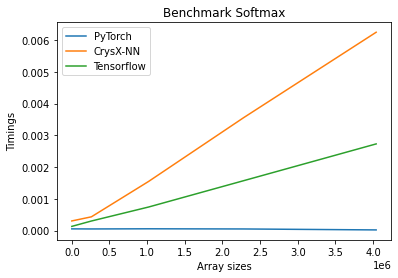

In [ ]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Softmax')
plt.show()


## Benchmark Softmax derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function.

Therefore, it is not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

#### Update: Seems to be really problematic to get the jacobian of Softmax wrt inputs in an efficient manner using the PyTorch framework. 

There are ways in which you can do it, but they would be slow. (https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16)

So take the timing results with a grain of salt.

In [ ]:
def tf_softmax_grad(z):
#   z = tf.constant(z, dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(z)
        a = tf.nn.softmax(z) 
    jacob = g.batch_jacobian(a, z)
    return jacob#.numpy()

In [ ]:
# Reference: https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16
def torch_softmax_grad(wrt):
    jacobian = []
    softmax_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
    softmax_func.eval()
    for i in range(wrt.shape[0]):
        jac = torch.autograd.functional.jacobian(softmax_func, wrt[i])
        jacobian.append(jac)
        #
    return torch.stack(jacobian, 0)

### Confirm that all frameworks give the same results

In [ ]:
# Torch input
X_torch = torch.randn((100,100),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
# softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
softmax_torch_value = softmax_torch_func(X_torch)
device = 'cuda'
gradientsTorch = torch_softmax_grad(X_torch)#torch.autograd.grad(outputs=softmax_torch_value, inputs=X_torch,
#                           grad_outputs=torch.ones(softmax_torch_value.size()).to(device),
#                           create_graph=True, retain_graph=True, only_inputs=True)[0]
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Softmax_grad(X_cupy)
# print(gradientsCrysx)

# Tensorflow
# softmax_tf_value = tf.nn.softmax(X_tf)
gradientsTF = tf_softmax_grad(X_tf)
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - cp.asnumpy(gradientsCrysx)).max())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/autograd/functional.py:482: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = func(*inputs)


Max abs diff b/w torch and tf 1.4901161e-08
Max abs diff b/w torch and CrysX 2.2351742e-08


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [ ]:
# Torch
print('PyTorch')
%timeit -n 2 torch_softmax_grad(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 2 Softmax_grad(X_cupy)

# Tensorflow
print('Tensorflow')
%timeit -n 2 tf_softmax_grad(X_tf)


PyTorch
3.1 s ± 98.3 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
CrysX-NN (crysx_nn)


KeyboardInterrupt: ignored

Exception ignored in: 'cupy._core._kernel._can_cast'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in can_cast
KeyboardInterrupt


TypeError: ignored